In [1]:
!aws s3 sync s3://rowerki ./data

In [2]:
# univariate multi-step encoder-decoder convlstm
import sys, os
sys.path.append('..')
import utils
import numpy as np
import pandas as pd
from math import sqrt
import json
import matplotlib.pyplot as plt
from numpy import split
from numpy import array
from datetime import datetime, timedelta 
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import LSTM
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras.layers import ConvLSTM2D

In [3]:
# split a univariate dataset into train/test sets
def split_dataset(data):
    # split into standard weeks
    train, test = data[1:-328], data[-328:-6]
    # restructure into windows of weekly data
    train = array(split(train, len(train)/7))
    test = array(split(test, len(test)/7))
    return train, test
 
# evaluate one or more weekly forecasts against expected values
def evaluate_forecasts(actual, predicted):
    scores = list()
    # calculate an RMSE score for each day
    for i in range(actual.shape[1]):
        # calculate mse
        mse = mean_squared_error(actual[:, i], predicted[:, i])
        # calculate rmse
        rmse = sqrt(mse)
        # store
        scores.append(rmse)
    # calculate overall RMSE
    s = 0
    for row in range(actual.shape[0]):
        for col in range(actual.shape[1]):
            s += (actual[row, col] - predicted[row, col])**2
    score = sqrt(s / (actual.shape[0] * actual.shape[1]))
    return score, scores
 
# summarize scores
def summarize_scores(name, score, scores):
    s_scores = ', '.join(['%.1f' % s for s in scores])
    print('%s: [%.3f] %s' % (name, score, s_scores))
 
# convert history into inputs and outputs
def to_supervised(train, n_input, n_out=7):
    # flatten data
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2]))
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(len(data)):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, 0]
            x_input = x_input.reshape((len(x_input), 1))
            X.append(x_input)
            y.append(data[in_end:out_end, 0])
        # move along one time step
        in_start += 1
    return array(X), array(y)
 
# train the model
def build_model(train, n_steps, n_length, n_input):
    # prepare data
    train_x, train_y = to_supervised(train, n_input)
    # define parameters
    verbose, epochs, batch_size = 0, 20, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # reshape into subsequences [samples, time steps, rows, cols, channels]
    train_x = train_x.reshape((train_x.shape[0], n_steps, 1, n_length, n_features))
    # reshape output into [samples, timesteps, features]
    train_y = train_y.reshape((train_y.shape[0], train_y.shape[1], 1))
    # define model
    model = Sequential()
    model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=(n_steps, 1, n_length, n_features)))
    model.add(Flatten())
    model.add(RepeatVector(n_outputs))
    model.add(LSTM(200, activation='relu', return_sequences=True))
    model.add(TimeDistributed(Dense(100, activation='relu')))
    model.add(TimeDistributed(Dense(1)))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model
 
# make a forecast
def forecast(model, history, n_steps, n_length, n_input):
    # flatten data
    data = array(history)
    data = data.reshape((data.shape[0]*data.shape[1], data.shape[2]))
    # retrieve last observations for input data
    input_x = data[-n_input:, 0]
    # reshape into [samples, time steps, rows, cols, channels]
    input_x = input_x.reshape((1, n_steps, 1, n_length, 1))
    # forecast the next week
    yhat = model.predict(input_x, verbose=0)
    # we only want the vector forecast
    yhat = yhat[0]
    return yhat
 
# evaluate a single model
def evaluate_model(train, test, n_steps, n_length, n_input):
    # fit model
    model = build_model(train, n_steps, n_length, n_input)
    # history is a list of weekly data
    history = [x for x in train]
    # walk-forward validation over each week
    predictions = list()
    for i in range(len(test)):
        # predict the week
        yhat_sequence = forecast(model, history, n_steps, n_length, n_input)
        # store the predictions
        predictions.append(yhat_sequence)
        # get real observation and add to history for predicting the next week
        history.append(test[i, :])
    # evaluate predictions days for each week
    predictions = array(predictions)
    score, scores = evaluate_forecasts(test[:, :, 0], predictions)
    return score, scores
 

In [4]:
stations = utils.get_stations()
stations = stations[stations['place_type'] != '14'] #exclude electric stations, which are frequently very close to normal stations 
stations ['row'] = 0
stations ['col'] = 0
config = json.load(open('../config.json'))
bounding_rectangle = [[min(stations['lat']),max(stations['lat']) + config['bounding_frame_eps']], 
                      [min(stations['lng']),max(stations['lng'])  + config['bounding_frame_eps']]]
widths = [dimension[1] - dimension[0] for dimension in bounding_rectangle]
number_of_divisions = config['number_of_divisions']
for col in range(number_of_divisions): 
    for row in range(number_of_divisions): 
        station_in_rectangle = (stations['lat']>= (row)*widths[0]/number_of_divisions + bounding_rectangle[0][0]) &\
        (stations['lat']< (row+1)*widths[0]/number_of_divisions + bounding_rectangle[0][0]) &\
        (stations['lng']>= (col)*widths[1]/number_of_divisions + bounding_rectangle[1][0]) &\
        (stations['lng']< (col+1)*widths[1]/number_of_divisions + bounding_rectangle[1][0])
        if sum(station_in_rectangle) >1:
            raise(Exception("More than 1 station"))   
        if sum(station_in_rectangle) ==1:
            stations.loc[station_in_rectangle, ["row", "col"]] = [number_of_divisions - row - 1, col]
bikes = utils.read_bikes()
grouped = utils.rented_returned_amount(bikes, stations)
del bikes 
grouped = grouped.set_index("date").groupby(["lat", "lng", "row", "col"]).resample('h').agg({"bike_count": 'last', "just_returned": sum, "just_rented": sum}).reset_index()
grouped 

,lat,lng,row,col,date,bike_count,just_returned,just_rented
0,52.116353,21.087702,307,268,2022-04-24 15:00:00,25.0,26,1.0
1,52.116353,21.087702,307,268,2022-04-24 16:00:00,18.0,2,4.0
2,52.116353,21.087702,307,268,2022-04-24 17:00:00,11.0,8,20.0
3,52.116353,21.087702,307,268,2022-04-24 18:00:00,8.0,0,3.0
4,52.116353,21.087702,307,268,2022-04-24 19:00:00,8.0,0,0.0
...,...,...,...,...,...,...,...,...
334548,52.350106,20.945616,0,94,2022-06-04 13:00:00,6.0,0,0.0
334549,52.350106,20.945616,0,94,2022-06-04 14:00:00,4.0,2,2.0
334550,52.350106,20.945616,0,94,2022-06-04 15:00:00,6.0,1,0.0
334551,52.350106,20.945616,0,94,2022-06-04 16:00:00,5.0,0,1.0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


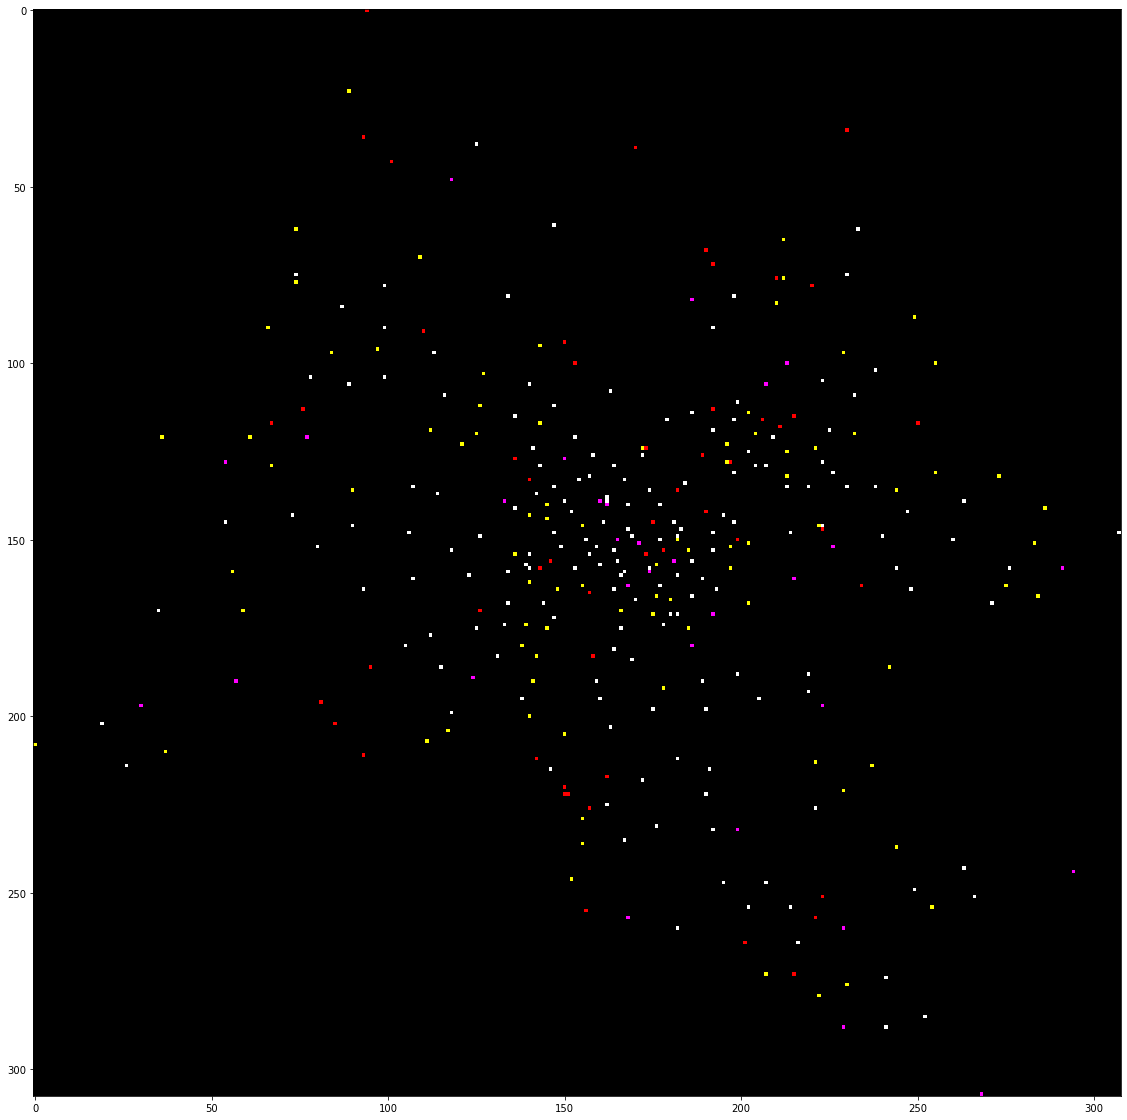

In [5]:
imgs = {}
for dt in grouped['date'].unique(): 
    img = np.zeros([number_of_divisions, number_of_divisions, 3])
    for stats in grouped[grouped['date'] == dt].to_dict('records'):
        img[stats['row'], stats['col'], :] = [stats["bike_count"],stats["just_returned"],stats["just_rented"]]
    imgs[dt] = img
plt.figure(figsize=(20,20))
plt.imshow(list(imgs.values())[3])

In [6]:
del grouped 

In [7]:
train, test = [], []
for day, image in sorted(imgs.items(), key=lambda x: x[0]):
    day = pd.to_datetime(day)
    if (day >= datetime.now() - timedelta(days=6)) and (day <= datetime.now() - timedelta(days=1)):
        train.append(image)
    if (day >= datetime.now() - timedelta(days=1)):
        test.append(image)
del imgs
train = np.array(train)
train.shape

(120, 308, 308, 3)

In [8]:
# convert history into inputs and outputs
def to_supervised(data, n_input=7, n_out=3): 
    X, y = list(), list()
    in_start = 0
    # step over the entire history one time step at a time
    for _ in range(data.shape[0]):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_out
        # ensure we have enough data for this instance
        if out_end <= len(data):
            x_input = data[in_start:in_end, :] 
            X.append(x_input)
            y.append(data[in_end:out_end, :])
        # move along one time step
        in_start += 1
    return array(X), array(y)
X_train, y_train = to_supervised(train)
X_train.shape

(111, 7, 308, 308, 3)

In [10]:
y_train.shape

(111, 3, 308, 308, 3)

In [12]:
verbose, epochs, batch_size = 0, 20, 16     
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,3), activation='relu', input_shape=X_train.shape[1:]))
model.add(Flatten())
model.add(RepeatVector(y_train.shape[-1]))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(100, activation='relu')))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mse', optimizer='adam')
# fit network
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)

2022-06-04 17:57:38.479212: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (mklcpu) ran out of memory trying to allocate 17.98GiB (rounded to 19301990400)requested by op RandomUniform
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2022-06-04 17:57:38.479272: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for mklcpu
2022-06-04 17:57:38.479284: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-06-04 17:57:38.479292: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 0, Chunks in use: 0. 0B allocated for chunks. 0B in use in bin. 0B client-requested in use in bin.
2022-06-04 17:57:38.479299: I tensorflow/core/common_runtime/

ResourceExhaustedError: OOM when allocating tensor with shape[6031872,800] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator mklcpu [Op:RandomUniform]

In [ ]:
dataset = read_csv('household_power_consumption_days.csv', header=0, infer_datetime_format=True, parse_dates=['datetime'], index_col=['datetime'])
# split into train and test
train, test = split_dataset(dataset.values)
# define the number of subsequences and the length of subsequences
n_steps, n_length = 2, 7
# define the total days to use as input
n_input = n_length * n_steps
score, scores = evaluate_model(train, test, n_steps, n_length, n_input)
# summarize scores
summarize_scores('lstm', score, scores)
# plot scores
days = ['sun', 'mon', 'tue', 'wed', 'thr', 'fri', 'sat']
pyplot.plot(days, scores, marker='o', label='lstm')
pyplot.show()